In [1]:
# Cheng S et al. A pan-cancer single-cell transcriptional atlas of tumor infiltrating myeloid cells. Cell 2021 
# https://www.sciencedirect.com/science/article/pii/S0092867421000106
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE154763
# https://bedapub.github.io/besca/tutorials/notebook3_batch_correction.html
# https://stackoverflow.com/questions/43858836/python-installing-clarifai-vs14-0-link-exe-failed-with-exit-status-1158
# https://github.com/hiiiyilingzhang/PanMyeloid-assignment

In [2]:
# !pip install bbknn
# !pip install Scanorama
# !pip install besca

In [3]:
#!pip install git+https://github.com/Teichlab/bbknn.git
#https://github.com/bedapub/besca

In [4]:
#!mkdir data
#!mkdir write
#!mkdir figures

In [5]:
import time; start = time.time()

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [7]:
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
#import sc_toolbox.api as sct
import seaborn as sns
import pandas as pd
import scanpy as sc
import numpy as np
# import besca as bc
import scanorama
import bbknn
import six 
import sys
sys.modules['sklearn.externals.six'] = six
sc.logging.print_version_and_date()

Running Scanpy 1.9.1, on 2022-10-09 21:33.


In [8]:
sc.settings.set_figure_params(scanpy=True, dpi=150, dpi_save=150, color_map='coolwarm',facecolor='white',
                             format='png', transparent=False, frameon=False, vector_friendly=True, fontsize=14)
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.11 pynndescent==0.5.6


In [9]:
results_file = './write/pbmc3k.h5ad'          # the file that will store the analysis results
data_file    = "./data/GSE154763_UCEC_norm_expression.csv.gz"

In [10]:
adata = sc.read(
    results_file,                  # data file
    var_names='gene_symbols',      # use gene symbols for the variable names (variables-axis index)
    cache=True)                    # write a cache file for faster subsequent reading
adata.uns['log1p']["base"] = None  # Fix " KeyError: 'base' "

In [11]:
adata

AnnData object with n_obs × n_vars = 6254 × 2221
    obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'genes_index', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'MajorCluster_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'patient_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
print(adata.obs['patient'].value_counts())

P20190911    2857
P20190910    1732
P20181122     377
P20190305     357
P20190717     269
P20190213     263
P20190625     214
P20190312     145
P20181211      40
Name: patient, dtype: int64


In [13]:
sc.tl.pca(adata, svd_solver='arpack')  # Principal component analysis [Pedregosa11].

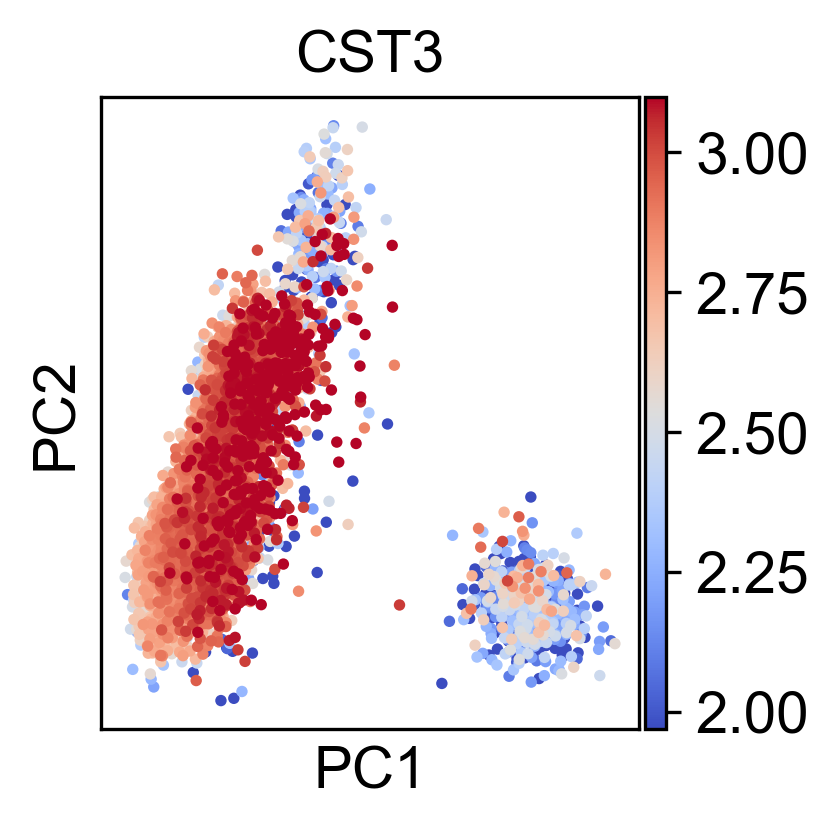

In [14]:
color='CST3'
fig,(ax1) = plt.subplots(1,1, figsize=(3,3))
ax1 = sc.pl.pca(adata, color=color, size=30, colorbar_loc="right", 
                vmin="p5", vmax="p95", show=False, frameon=True, ax=ax1) #  Plot in the PCA coordinates
plt.tight_layout(); plt.savefig("./figures/02a.PCA.png", bbox_inches="tight")

In [15]:
# sc.pl.pca_variance_ratio(adata, n_pcs=20, log=False, show=None, save=None)

In [16]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) # Compute the neighborhood graph of cells using the PCA representation of the data matrix.

In [17]:
%%time
sc.tl.umap(adata, min_dist=0.6, spread=1.0, n_components=2, maxiter=None, alpha=1.0, gamma=1.0,
           negative_sample_rate=5, init_pos='spectral', random_state=0, a=None, b=None, copy=False,
           method='umap', neighbors_key=None)  # Embed the neighborhood graph using UMAP [McInnes18].

Wall time: 12.5 s


In [18]:
sc.tl.leiden(adata, resolution=1, restrict_to=None, random_state=0, key_added='leiden', adjacency=None,
             directed=True, use_weights=True, n_iterations=- 1, partition_type=None, neighbors_key=None,
             obsp=None, copy=False)  # Cluster cells into subgroups [Traag18].

C:\Users\alber\AppData\Local\Temp/ipykernel_5524/2601892725.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.savefig("./figures/02ba.UMAP_PatientsPreBatches.png", bbox_inches="tight")


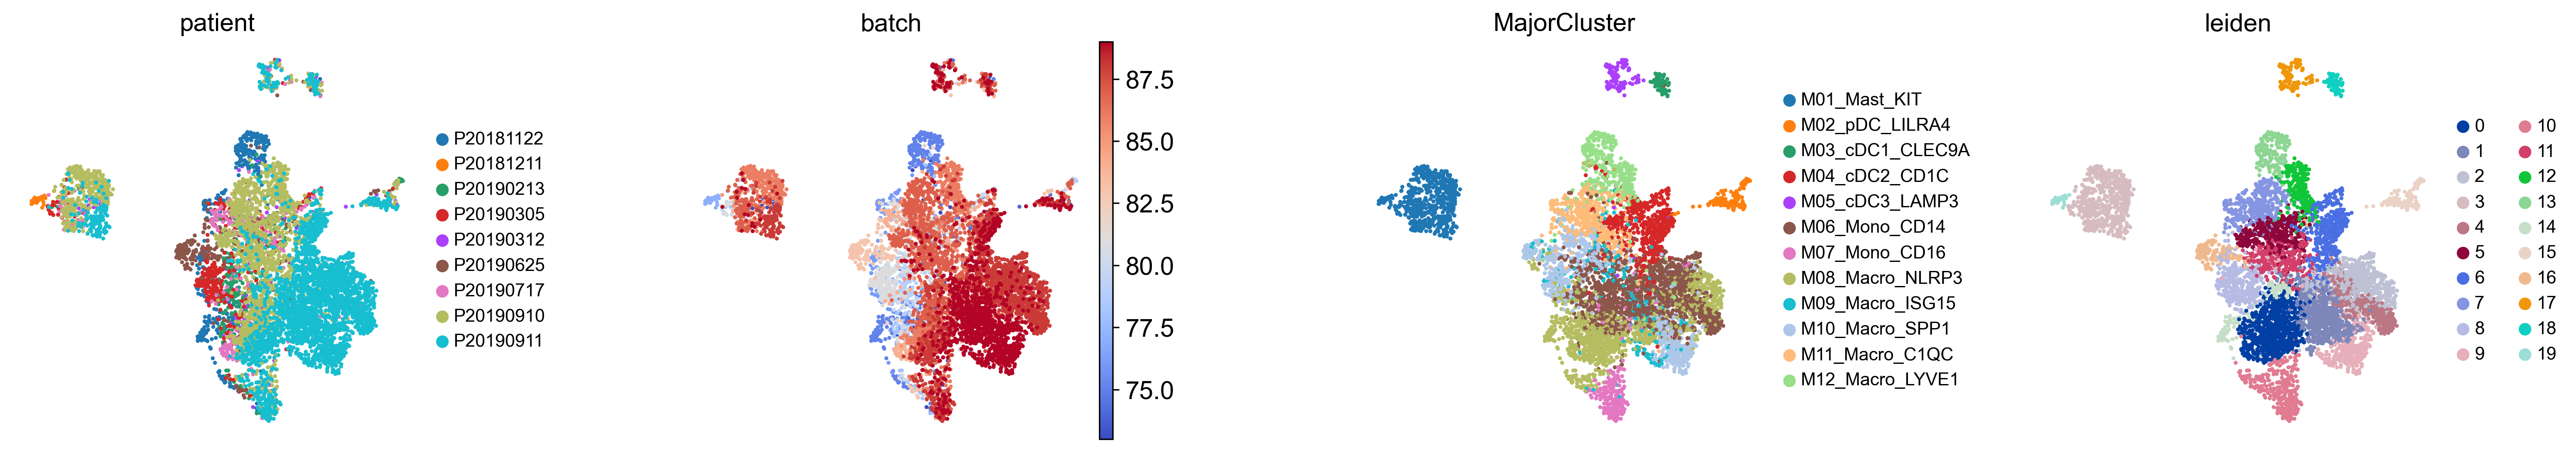

In [19]:
genes=['patient','batch','MajorCluster','leiden']
sc.pl.umap(adata, color=genes, ncols=4, wspace=0.5, hspace=0.25, s=20, color_map="coolwarm",
           legend_fontsize=10, use_raw=False, show=False)
plt.tight_layout(); plt.savefig("./figures/02ba.UMAP_PatientsPreBatches.png", bbox_inches="tight")

In [20]:
bbknn.bbknn(adata, batch_key='patient', n_pcs=100)    # remove the batch effects from different donors

In [21]:
%%time
sc.tl.pca(adata, svd_solver='arpack')  # Principal component analysis [Pedregosa11].
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata, min_dist=0.6, spread=1.0, n_components=2, maxiter=None, alpha=1.0, gamma=1.0,
           negative_sample_rate=5, init_pos='spectral', random_state=0, a=None, b=None, copy=False,
           method='umap', neighbors_key=None)  # Embed the neighborhood graph using UMAP [McInnes18].

Wall time: 15.2 s


C:\Users\alber\AppData\Local\Temp/ipykernel_5524/3123017956.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.savefig("./figures/02bb.UMAP_PatientsPostBatches.png", bbox_inches="tight")


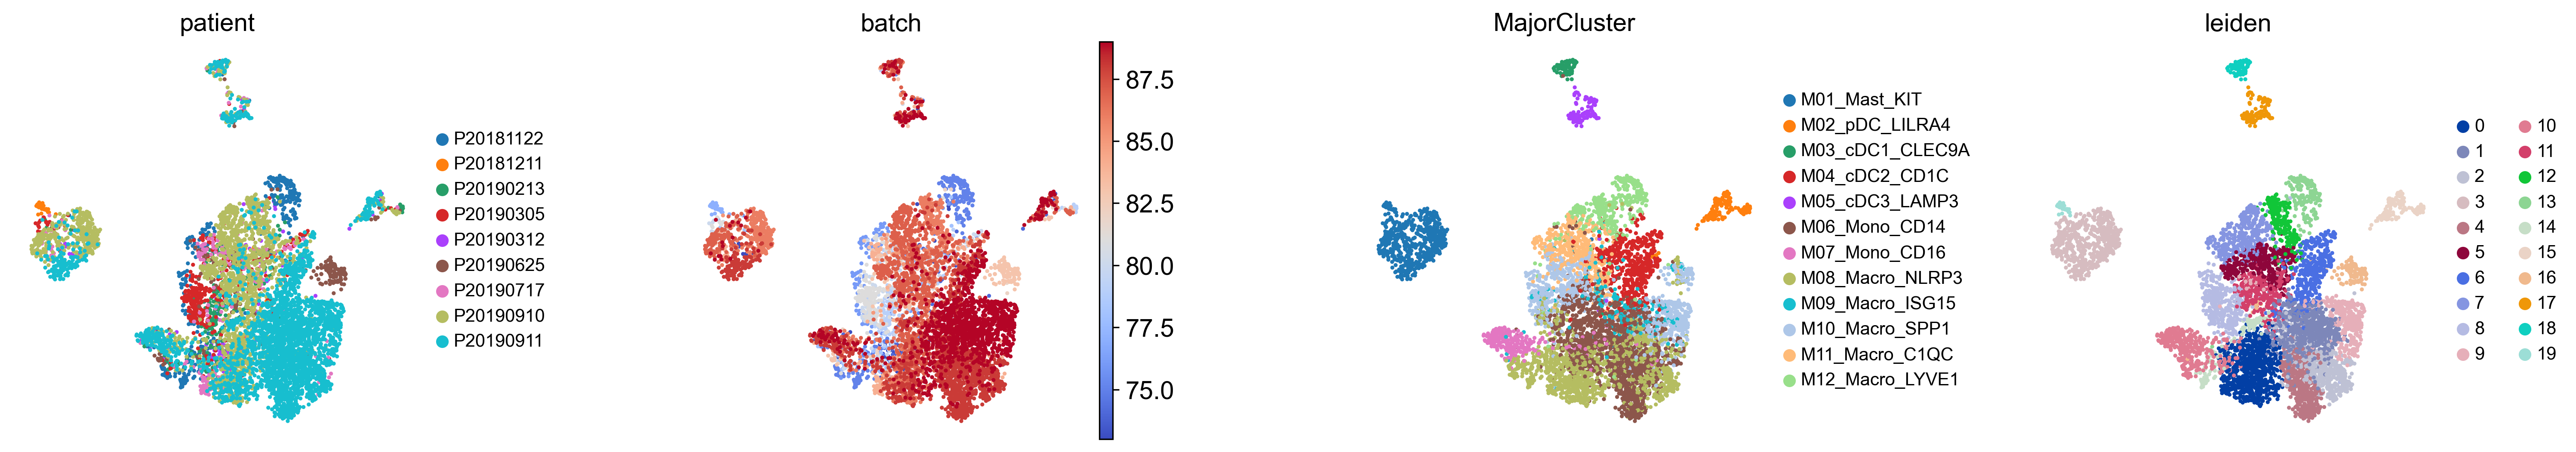

In [22]:
genes=['patient','batch','MajorCluster','leiden']
sc.pl.umap(adata, color=genes, ncols=4, wspace=0.5, hspace=0.25, s=20, color_map="coolwarm",
           legend_fontsize=10, use_raw=False, show=False, )
plt.tight_layout(); plt.savefig("./figures/02bb.UMAP_PatientsPostBatches.png", bbox_inches="tight")

C:\Users\alber\AppData\Local\Temp/ipykernel_5524/456155635.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.savefig("./figures/02c.UMAP_GenesOfInterest.png", bbox_inches="tight")


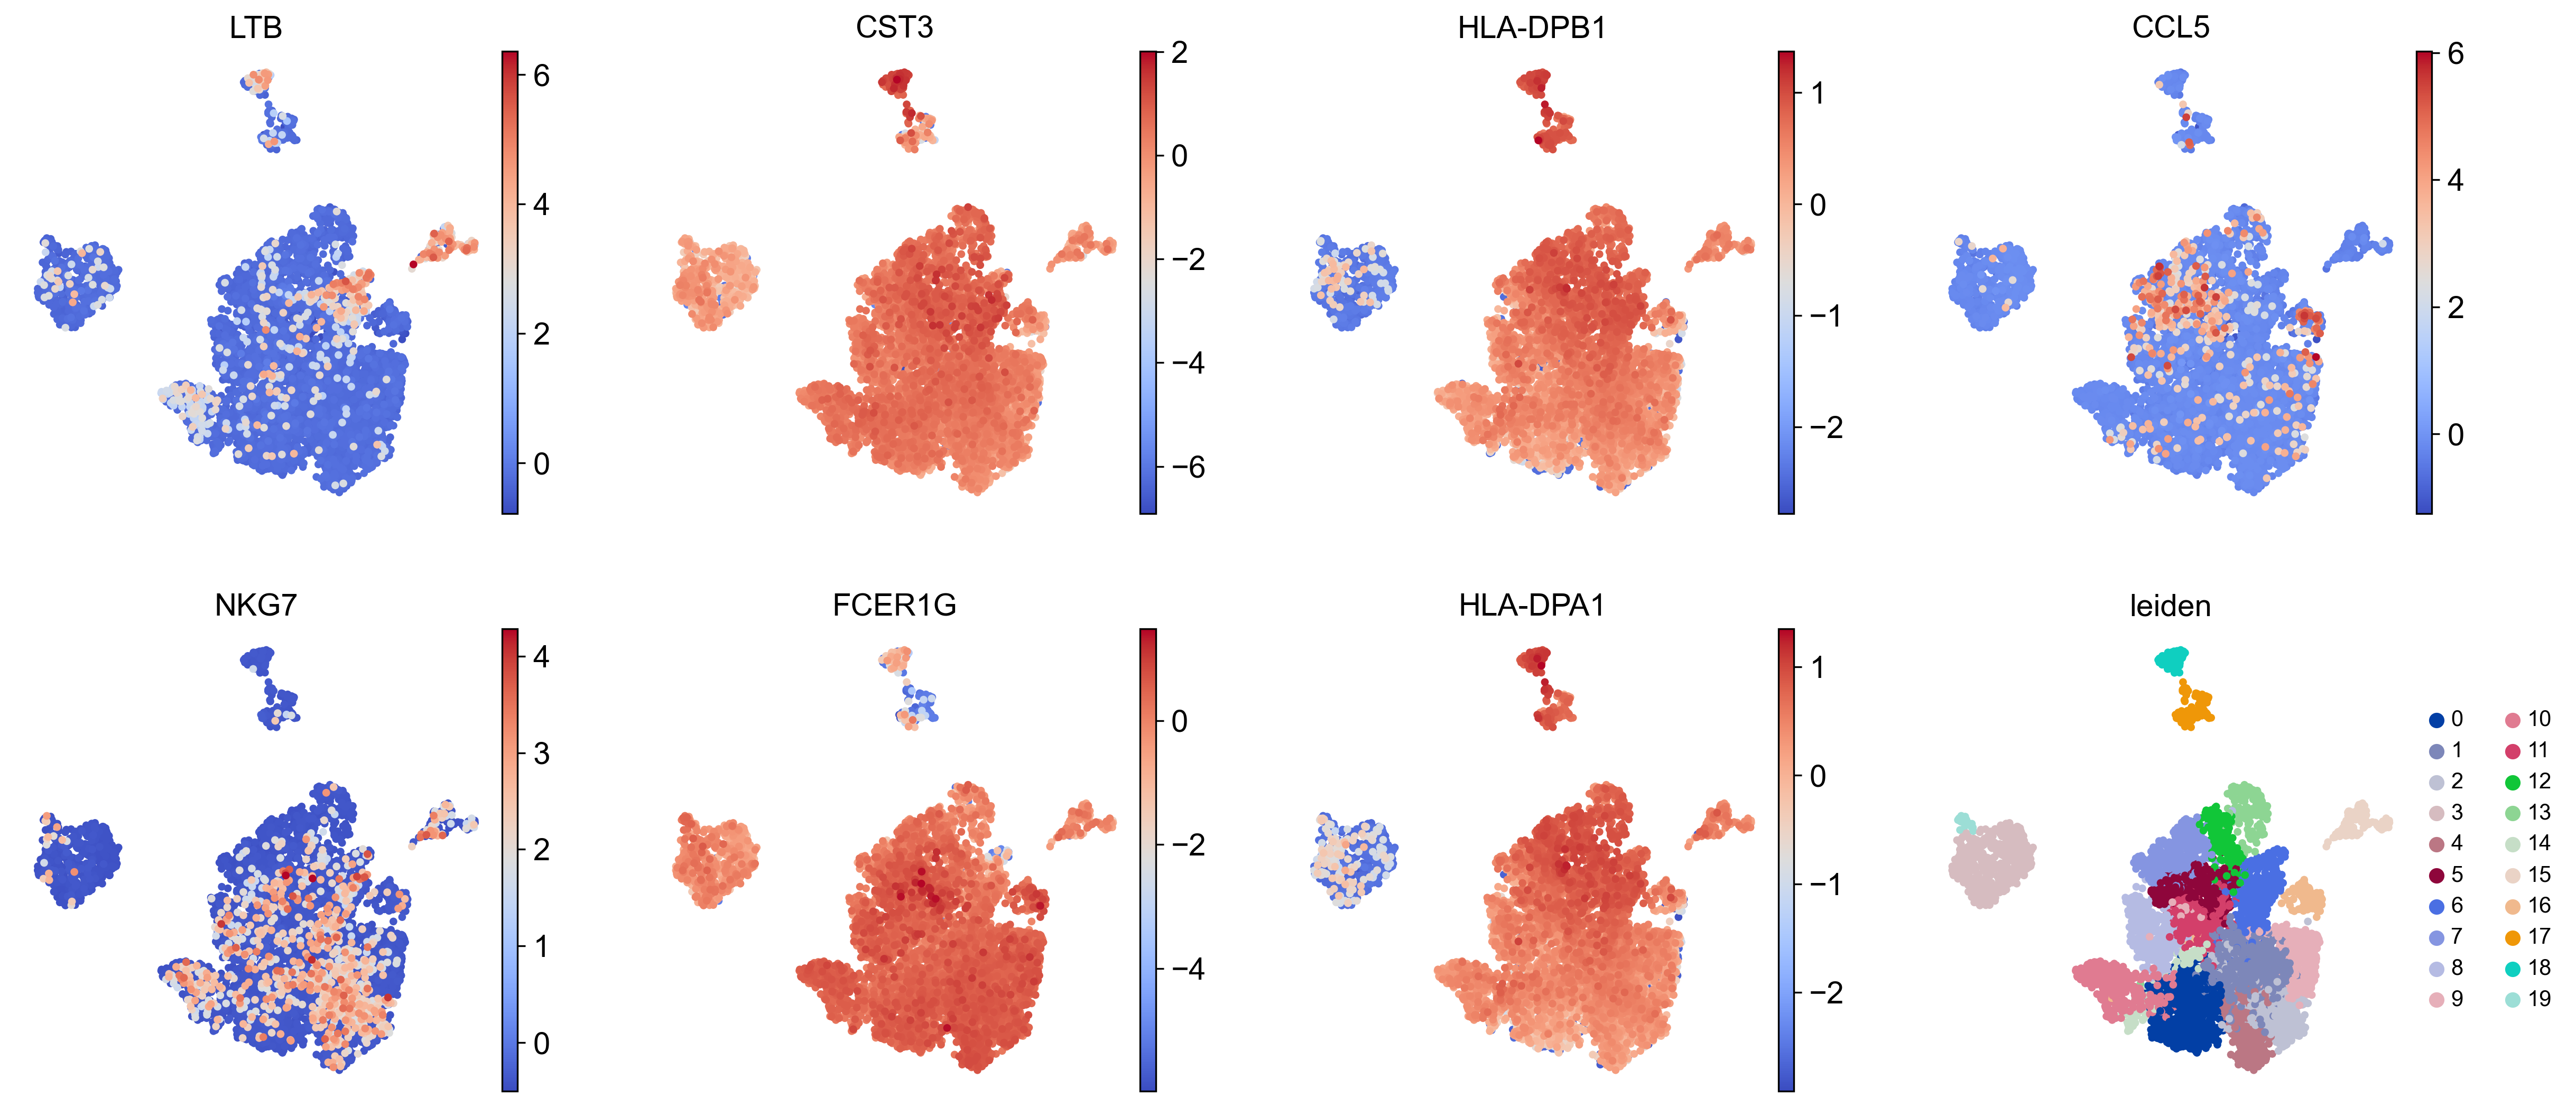

In [23]:
genes=['LTB','CST3','HLA-DPB1','CCL5','NKG7','FCER1G','HLA-DPA1','leiden']
sc.pl.umap(adata, color=genes, ncols=4, s=50, color_map="coolwarm",
           legend_fontsize=10, use_raw=False, show=False)
plt.tight_layout(); plt.savefig("./figures/02c.UMAP_GenesOfInterest.png", bbox_inches="tight")

In [24]:
# Remove Batches from Platforms
"""We run two rounds of Scanorama (Hie et al., 2019), an algorithm that could identify and merge shared cell types among multiple datasets,
to remove the batch effects within scRNA-seq datasets of 15 cancer types. First, we applied Scanorama to datasets generated from 3′ library
and 5′ library from 10x Genomics to remove the batch effects attribute to these two protocols. Then, a second-round of Scanorama was applied
to remove the batch effects resulting from the diverse platforms, including 10x Genomics, MARS-Seq and inDrop.""" 

'We run two rounds of Scanorama (Hie et al., 2019), an algorithm that could identify and merge shared cell types among multiple datasets,\nto remove the batch effects within scRNA-seq datasets of 15 cancer types. First, we applied Scanorama to datasets generated from 3′ library\nand 5′ library from 10x Genomics to remove the batch effects attribute to these two protocols. Then, a second-round of Scanorama was applied\nto remove the batch effects resulting from the diverse platforms, including 10x Genomics, MARS-Seq and inDrop.'

In [25]:
adata2 = adata.raw.to_adata()

In [26]:
print(adata.obs['tech'].value_counts())

10X5    6254
Name: tech, dtype: int64


In [27]:
# Create individual AnnData objects from each of the datasets.
# Vplit per batch into 10X objects.
batches = adata.obs['tech'].cat.categories.tolist()
#del batches[2]
data_10X = {}
for batch in batches:
    data_10X[batch] = adata2[adata.obs['tech'] == batch]

data_10X

{'10X5': View of AnnData object with n_obs × n_vars = 6254 × 2221
     obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
     var: 'genes_index', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'MajorCluster_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'patient_colors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap'
     obsp: 'connectivities', 'distances'}

In [28]:
data_10X_ann = adata2[adata2.obs["tech"] != "SmartSeq2", :]
data_10X_ann

View of AnnData object with n_obs × n_vars = 6254 × 2221
    obs: 'percent_mito', 'n_counts', 'percent_hsp', 'barcode', 'batch', 'library_id', 'cancer', 'patient', 'tissue', 'n_genes', 'MajorCluster', 'source', 'tech', 'UMAP1', 'UMAP2', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'genes_index', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'MajorCluster_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'patient_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [29]:
# check that the matrix looks like noramlized counts
print(data_10X_ann.X[1:10,1:10])

[[0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        1.186869 ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        1.6927083 0.        0.
  0.        0.       ]
 [0.        0.        1.8301958 2.3366709 0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        1.591632  0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]]


In [30]:
var_genes_all = adata.var.highly_variable
print("Highly variable genes: %d"%sum(var_genes_all))

Highly variable genes: 2221


In [31]:
# use batch_key to detect variable genes in each dataset separately
sc.pp.highly_variable_genes(data_10X_ann, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'tech')
print("Highly variable genes intersection: %d"%sum(data_10X_ann.var.highly_variable_intersection))

Highly variable genes intersection: 402


C:\Users\alber\anaconda3\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [32]:
print("Number of batches where gene is variable:")
print(data_10X_ann.var.highly_variable_nbatches.value_counts())

Number of batches where gene is variable:
0    1819
1     402
Name: highly_variable_nbatches, dtype: int64


In [33]:
var_genes_batch = data_10X_ann.var.highly_variable_nbatches > 0

In [34]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(data_10X_ann.var.highly_variable_nbatches == 2))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & data_10X_ann.var.highly_variable_intersection))

Any batch var genes: 402
All data var genes: 2221
Overlap: 402
Variable genes in all batches: 0
Overlap batch instersection and all: 402


In [35]:
var_select = data_10X_ann.var.highly_variable_nbatches >= 1
var_genes = var_select.index[var_select]
len(var_genes)

402

In [36]:
data_10X2 = dict()
for ds in data_10X.keys():
    print(ds)
    data_10X2[ds] = data_10X[ds][:,var_genes]

10X5


In [37]:
#convert to list of AnnData objects
data_10X2_adatas = list(data_10X2.values())

In [ ]:
%%time
# run scanorama.integrate
scanorama.integrate_scanpy(data_10X2_adatas, dimred = 100)

Found 402 genes among all datasets


In [ ]:
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.
data_10X2_adatas[0].obsm['X_scanorama'].shape

In [ ]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in data_10X2_adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object
data_10X_ann.obsm["Scanorama"] = all_s

In [ ]:
# tsne and umap
sc.pp.neighbors(data_10X_ann, n_pcs =100, use_rep = "Scanorama")
sc.tl.umap(data_10X_ann)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5),constrained_layout=True)
sc.pl.umap(data_10X_ann, color="MajorCluster", title="Scanorama ROUND1 umap", ax=axs[0], show=False)
sc.pl.umap(data_10X_ann, color="cancer", title="Scanorama ROUND1 umap", ax=axs[1], show=False)

In [ ]:
adata

In [ ]:
adata.write(results_file)   # Save the result.

In [ ]:
print("'02_Embedding.v001' script run time:", f'{time.time()-start:.0f}', "seconds.")